Plots win rate vs. varying adversary/victim visits.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import utils

utils.set_plot_formatting()

### A-MCTS-R and A-MCTS-S++ vs. varying victim visits

In [18]:
def plot_victim_visit_sweep(df, victim_label, plot_name):
    """Plot performance of A-MCTS-{R,S++}-v200 vs. varying victim visits."""
    utils.parse_for_match(df)
    fig, axs = plt.subplots(
        1,
        1,
        constrained_layout=True,
        figsize=(2.64049, 2),
        dpi=240,
    )

    (
        100
        * df.query("adv_name.str.contains('ov1') == False & victim_visits <= 128")
        .groupby("victim_visits")
        .mean(numeric_only=True)
        .adv_win
    ).plot(label="A-MCTS-R", zorder=10, linestyle="--")
    (
        100
        * df.query("adv_name.str.contains('ov1')")
        .groupby("victim_visits")
        .mean(numeric_only=True)
        .adv_win
    ).plot(label="A-MCTS-S++")

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(f"Adv. win \\% vs. {victim_label}")
    # plt.title("Adversary against cp505")
    plt.xlabel("Victim visits")
    plt.legend()

    max_victim_visits = df.victim_visits.max()
    major_ticks = [
        10**i for i in range(0, int(np.floor(np.log10(max_victim_visits))) + 1)
    ]
    minor_ticks = utils.flatten_2d_list(
        [list(range(i, min(10 * i, max_victim_visits + i), i)) for i in major_ticks]
    )
    plt.xticks(major_ticks)
    plt.xticks(minor_ticks, minor=True)

    plt.savefig(f"{plot_name}.pgf", backend="pgf")

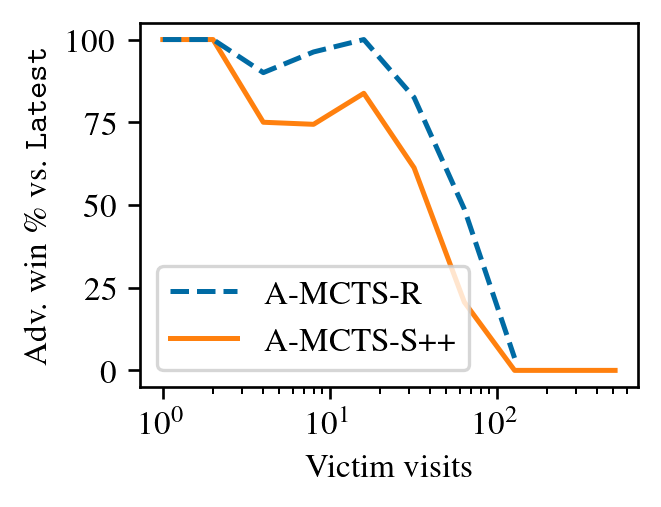

In [19]:
# adversary s34mil from unhardened training run
df = utils.parse_sgfs(
    [
        "/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling",
        "/nas/ucb/tony/go-attack/matches/cp505-ov1",
    ]
)
plot_victim_visit_sweep(df, "$\\texttt{Latest}$", "adv-vs-cp505-vary-visits")

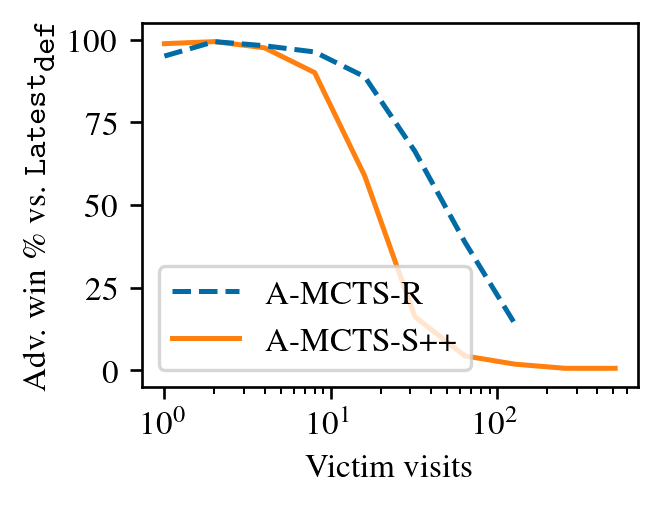

In [20]:
# adversary 349mil from hardened training run
df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-20221108-182437"]
)
plot_victim_visit_sweep(
    df, "$\\texttt{Latest}_\\texttt{def}$", "adv-vs-cp505h-vary-visits"
)

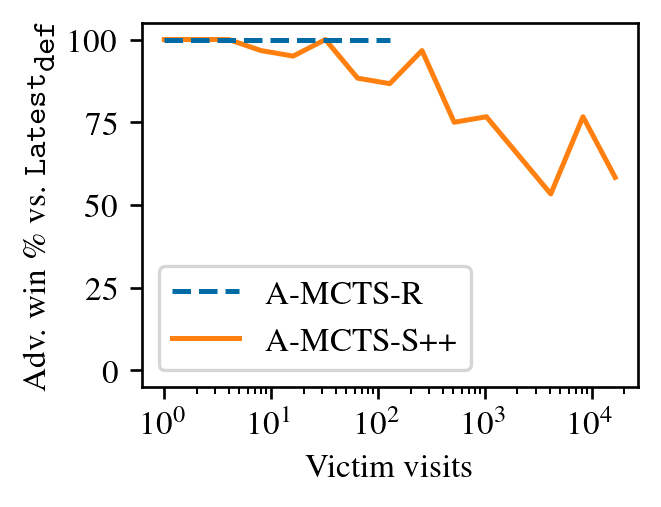

In [21]:
# adversary 497mil from hardened training run
df = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-s497m-20221114-214156",
        "/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-s497m-ov1-20221114-213705",
    ]
)
plot_victim_visit_sweep(
    df, "$\\texttt{Latest}_\\texttt{def}$", "adv-497mil-vs-cp505h-vary-visits"
)

### A-MCTS-S, varying adv. visits

In [22]:
def plot_adv_visit_sweep(df, df2, victim_visits, victim_label, plot_name):
    """Plot performance of A-MCTS-S with varying adversary visits.

    df = data for adversary visit sweep experiment
    df2 = data for victim visit sweep experiment
    """
    utils.parse_for_match(df)
    utils.parse_for_match(df2)

    visit_query = f"victim_visits == {victim_visits}"
    print(
        "A-MCTS-S win rate:\n",
        df.query(visit_query).groupby("adv_visits").mean(numeric_only=True).adv_win,
    )

    df2_points = (
        df2.query(visit_query).groupby("adv_name").mean(numeric_only=True).adv_win
    )
    print("A-MCTS-{S++,R} win rate:\n", df2_points)
    assert df2_points.shape[0] <= 2
    splusplus_point = None
    perfect_modeling_point = None
    for name in df2_points.index:
        if "ov1" in name:
            splusplus_point = df2_points[name]
        else:
            perfect_modeling_point = df2_points[name]

    fig, ax = plt.subplots(
        1,
        1,
        constrained_layout=True,
        figsize=(2.64049, 2),
        dpi=240,
    )

    (
        100
        * df.query(visit_query).groupby("adv_visits").mean(numeric_only=True).adv_win
    ).plot(label="A-MCTS-S")

    if splusplus_point is not None:
        plt.plot(
            200,
            100 * splusplus_point,
            "+",
            label="A-MCTS-S++",
            markersize=10,
            color="tab:red",
        )

    if perfect_modeling_point is not None:
        plt.plot(
            200,
            100 * perfect_modeling_point,
            "o",
            label="A-MCTS-R",
            markersize=6,
            color="tab:green",
        )

    plt.ylim(-5, 105)
    plt.xscale("log")

    # https://stackoverflow.com/a/73094650/1337463
    from matplotlib import ticker as mticker

    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    plt.xlabel(f"Adversary visits")
    plt.ylabel(f"Adv. win \\% vs. {victim_label}")
    plt.legend()
    # smaller font size to avoid covering up points
    # plt.legend(prop={"size": 8})
    plt.savefig(f"{plot_name}.pgf", backend="pgf")

A-MCTS-S win rate:
 adv_visits
1       0.134615
2       0.192308
4       0.280000
8       0.229167
16      0.140000
32      0.240000
64      0.267857
128     0.230769
256     0.288462
512     0.230769
1024    0.407407
2048    0.375000
4096    0.540000
8192    0.481481
Name: adv_win, dtype: float64
A-MCTS-{S++,R} win rate:
 adv_name
adv-s34090496-v200        0.48750
adv-s34090496-v200-ov1    0.20625
Name: adv_win, dtype: float64


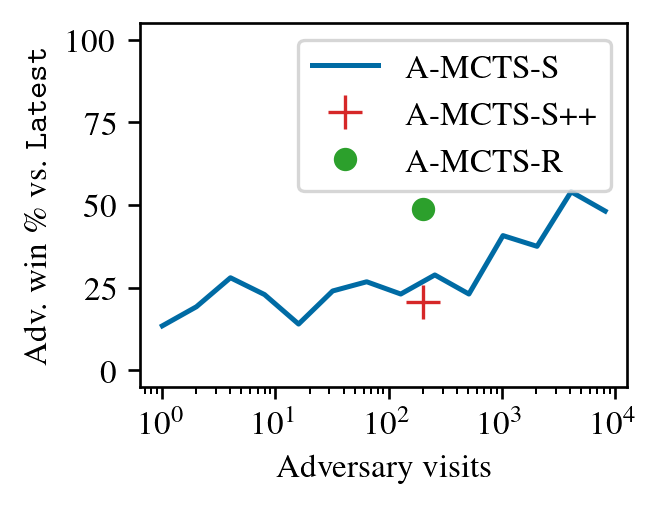

In [23]:
df = utils.parse_sgfs(
    ["/nas/ucb/tony/go-attack/matches/cp505-v64-vs-adv-1-to-8192/sgfs"]
)
df2 = utils.parse_sgfs(
    [
        "/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling",
        "/nas/ucb/tony/go-attack/matches/cp505-ov1",
    ]
)
plot_adv_visit_sweep(df, df2, 64, "$\\texttt{Latest}$", "adv-vs-cp505-vary-visits2")

A-MCTS-S win rate:
 adv_visits
1       0.020000
2       0.026667
4       0.053333
8       0.066667
16      0.106667
32      0.133333
64      0.140000
128     0.193333
256     0.160000
512     0.180000
1024    0.273333
2048    0.206667
4096    0.180000
8192    0.280000
Name: adv_win, dtype: float64
A-MCTS-{S++,R} win rate:
 adv_name
adv-s349284096-v200        0.6625
adv-s349284096-v200-ov1    0.1625
Name: adv_win, dtype: float64


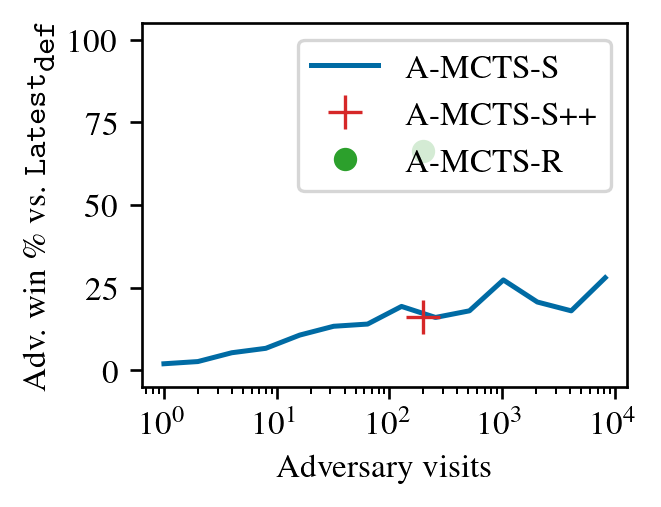

In [24]:
df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-v-sweep-v16-v32-20221109-102538"]
)
df2 = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-20221108-182437"]
)
plot_adv_visit_sweep(
    df, df2, 32, "$\\texttt{Latest}_\\texttt{def}$", "adv-vs-cp505h-v32-vary-adv-visits"
)

['adv-s497721856-v200' 'adv-s497721856-v200-ov1']
A-MCTS-S win rate:
 adv_visits
1       0.075758
2       0.121212
4       0.196970
8       0.203125
16      0.250000
32      0.468750
64      0.593750
128     0.656250
256     0.671875
512     0.796875
1024    0.750000
2048    0.781250
4096    0.796875
8192    0.727273
Name: adv_win, dtype: float64
A-MCTS-{S++,R} win rate:
 adv_name
adv-s497721856-v200-ov1    0.65
Name: adv_win, dtype: float64


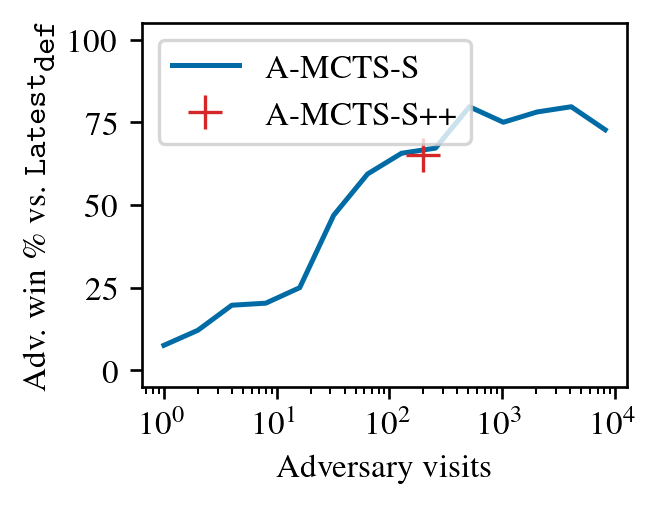

In [25]:
df = utils.parse_sgfs(
    ["/nas/ucb/k8/go-attack/match/ttseng-hard-adv-v-sweep-s497m-20221114-215552"]
)
df2 = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-s497m-20221114-214156",
        "/nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-s497m-ov1-20221114-213705",
    ]
)
print(df2.adv_name.unique())
plot_adv_visit_sweep(
    df,
    df2,
    2048,
    "$\\texttt{Latest}_\\texttt{def}$",
    "adv-497mil-vs-cp505h-v2048-vary-adv-visits",
)